### Import libraries

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, r'C:\Users\HP\Desktop\shiftdataportal_data')
from src.sdp_data.utils.translation import CountryTranslatorFrenchToEnglish

## **Load Data**

In [91]:
# old non processed data (input Dataiku)
df_us_eia_oil = pd.read_csv('..//..//src//sdp_data//data//Fossil_import_export_project//us_eia_oil.csv')
df_us_eia_gas = pd.read_csv('..//..//src//sdp_data//data//Fossil_import_export_project//us_eia_gas.csv')
df_us_eia_coal = pd.read_csv('..//..//src//sdp_data//data//Fossil_import_export_project//us_eia_coal.csv')

# old processed data (output Dataiku)
df_us_eia_processed = pd.read_csv('..//..//src//sdp_data//data//Fossil_import_export_project//FOSSIL_IMPORT_EXPORT_us_eia_fossil_zones_prod.csv')

# new data (using eia api)
eia_api_new = pd.read_csv('..//..//src//sdp_data//data//_raw//eia//eia_api_intl_1998_2021.csv')

# country data
df_country_old = pd.read_csv('..//..//src//sdp_data//data//Country//country_groups_prod.csv')
df_country_new = pd.read_csv('..//..//src//sdp_data//data//country_groups_old.csv')

## **Utils**

In [92]:
def subtract(series1, series2):
    return series1 - series2

def divide(series1, series2):
    return series1.div(series2)

# Constructing the dictionary
operation_dict = {
    'subtract': subtract,
    'divide': divide
}

def data_intersection(df_0, df_1):
        
    df_0 = df_0.sort_index()
    df_1 = df_1.sort_index()
    
    common_indices = df_0.index.intersection(df_1.index)
    
    df_0 = df_0.loc[common_indices].reset_index()
    df_1 = df_1.loc[common_indices].reset_index()

    return df_0, df_1
    
def diff_evaluation(df_0, df_1, indices_col, col_diff_to_check, operation='substract'):
    """
    Evaluate differences between two dataframes based on a specified operation.
    """
    df_0 = df_0.dropna(subset=indices_col)
    df_1 = df_1.dropna(subset=indices_col)
    
    df_0 = df_0.drop_duplicates(subset=indices_col)
    df_1 = df_1.drop_duplicates(subset=indices_col)
    
    df_0 = df_0.set_index(indices_col)
    df_1 = df_1.set_index(indices_col)

    # Dataframe intersection
    df_0_common, df_1_common = data_intersection(df_0, df_1)

    ratio = operation_dict[operation](df_0_common[col_diff_to_check], df_1_common[col_diff_to_check])
    if operation == 'divide':
        ratio = ratio[(ratio>0.000001)&(ratio<100000)]

    # Returning statistics including Coefficient of Variation (CV)
    min_ratio = ratio.min()
    max_ratio = ratio.max()
    median_ratio = ratio.median()
    mean_ratio = ratio.mean()
    cv_ratio = ratio.std() / mean_ratio if mean_ratio != 0 else None
    
    return min_ratio, max_ratio, median_ratio, mean_ratio, cv_ratio


def check_net_imports(df):
    
    imports_df = df[df['type'] == 'Imports'].sort_values(['group_name', 'year', 'energy_source', 'type']).reset_index(drop=True)
    exports_df = df[df['type'] == 'Exports'].sort_values(['group_name', 'year', 'energy_source', 'type']).reset_index(drop=True)
    net_imports_df = df[df['type'] == 'Net Imports'].sort_values(['group_name', 'year', 'energy_source', 'type']).reset_index(drop=True)
    
    # Merge the dataframes
    merged_df = imports_df.merge(exports_df, on=['group_name', 'year', 'energy_source'], suffixes=('_import', '_export'))
    merged_df = merged_df.merge(net_imports_df, on=['group_name', 'year', 'energy_source'])
    
    # Calculate Imports - Exports and compare it to Net Imports
    merged_df['calculated_net_imports'] = merged_df['energy_import'] - merged_df['energy_export']
    merged_df['difference'] = merged_df['calculated_net_imports'] - merged_df['energy']
    
    # Display discrepancies (if any)
    discrepancies = merged_df[abs(merged_df['difference']) > 1e-6]  # Adjust the tolerance as needed
    discrepancies = discrepancies[['group_name', 'year', 'energy_source', 'calculated_net_imports', 'energy', 'difference']]
    return discrepancies

def compare_python_dataiku_dataframes(res_dataiku, res_python, country_col, val_col, indx_col, translation=False, delete=False):
    
    if translation:
        if 'group_type' in indx_col:   
            res_dataiku[res_dataiku.group_type.isin(['country'])][country_col] = CountryTranslatorFrenchToEnglish().run(res_dataiku.copy()[res_dataiku.group_type.isin(['country'])][country_col], raise_errors=False)
        else:
            res_dataiku[country_col] = CountryTranslatorFrenchToEnglish().run(res_dataiku.copy()[country_col], raise_errors=False)
        if delete:
            res_dataiku = res_dataiku[res_dataiku[country_col] != "Delete"]
        
    res_python = res_python.sort_values(indx_col).reset_index(drop=True)
    res_dataiku = res_dataiku.sort_values(indx_col).reset_index(drop=True)
    res_python[val_col] = round(res_python[val_col],3)
    res_dataiku[val_col] = round(res_dataiku[val_col],3)

    # Merging the two dataframes on the unique identifier with an outer join
    merged_df = pd.merge(res_dataiku, res_python, on=res_python.columns.to_list(), 
                         suffixes=('_res_dataiku', '_res_python'), how='outer', indicator=True)
    # Identifying rows that are only in one DataFrame or have discrepancies 
    # 'left_only' and 'right_only' indicate rows unique to df1 and df2, respectively
    unique_or_diff_df = merged_df[(merged_df['_merge'] != 'both')]
    if len(unique_or_diff_df)==0:
        print("\033[1mresults are similar\033[0m")
    else:
        return unique_or_diff_df

def check_country_names(res_old, res_new, country_col):
    
    country_old = [x for x in res_old[country_col].unique() if x not in res_new[country_col].unique()]
    country_new = [y for y in res_new[country_col].unique() if y not in res_old[country_col].unique()]
    return country_old, country_new


## **Check the data generated by dataiku**

In [93]:
df_us_eia_processed.head()

,group_type,group_name,type,energy_source,year,energy,energy_unit,source
0,country,Bhutan,Net Imports,Gas,2003,0.000000,bcf,US EIA
1,country,Ukraine,Net Imports,Coal,1999,2.163414,Mtoe,US EIA
2,country,Jamaica,Net Imports,Coal,1987,0.000000,Mtoe,US EIA
3,country,Bhutan,Net Imports,Gas,1992,0.000000,bcf,US EIA
4,country,Uruguay,Net Imports,Coal,2007,0.000263,Mtoe,US EIA


In [94]:
df_us_eia_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63717 entries, 0 to 63716
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   group_type     63717 non-null  object 
 1   group_name     63717 non-null  object 
 2   type           63717 non-null  object 
 3   energy_source  63643 non-null  object 
 4   year           63717 non-null  int64  
 5   energy         63717 non-null  float64
 6   energy_unit    63717 non-null  object 
 7   source         63717 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.9+ MB


Avant de procéder à la traduction du traitement de Dataiku en code Python, nous vérifions si les 'Importations Nettes' correspondent à 'Importations' moins 'Exportations' pour chaque pays, année et source d'énergie. En utilisant la fonction ci-dessous, nous remarquons que les données présentent un problème, dans certaines cas les Importations Nettes ne sont pas égales à Importations - Exportations. Je prendrai donc en compte ce problème dans mon code pour le résoudre.

In [95]:
discrepancies = check_net_imports(df_us_eia_processed)
discrepancies

,group_name,year,energy_source,calculated_net_imports,energy,difference
6944,Germany,1980,Coal,5.489169,5.257735,0.231434
6945,Germany,1980,Coal,-0.873087,5.257735,-6.130822
6946,Germany,1980,Coal,6.130822,5.257735,0.873087
6947,Germany,1980,Coal,-0.231434,5.257735,-5.489169
6948,Germany,1980,Oil,602.241000,2407.553000,-1805.312000
...,...,...,...,...,...,...
7031,Germany,1990,Gas,1813.310000,2034.310000,-221.000000
7032,Germany,1990,Oil,402.673000,1778.088000,-1375.415000
7033,Germany,1990,Oil,402.673000,1778.088000,-1375.415000
7034,Germany,1990,Oil,1375.415000,1778.088000,-402.673000


In [96]:
discrepancies.group_name.unique()

array(['Germany'], dtype=object)

## **Traduction Dataiku => python (avec données ancien)**

In [97]:
class FossilProvenReservesProdGeneratorOLD:
    
    def __init__(self):
        # Initialize any necessary variables or state here
        pass
        
    def process(self, df):
        df["year"] = df["year"].astype(int)
        df["energy"] = df["energy"].str.replace(" ", "").replace("-", "")
        df['energy'] = pd.to_numeric(df['energy'], errors='coerce')
        return df


        return row
    def run(self, df_us_eia_oil, df_us_eia_gas, df_us_eia_coal, df_country):
        
        df_us_eia_oil = pd.melt(df_us_eia_oil, id_vars=["country", "energy_unit", "energy_source", "type", "subtype", "subsubtype", "subsubsubtype"], var_name='year', value_name='energy')
        df_us_eia_gas = pd.melt(df_us_eia_gas, id_vars=["country", "energy_unit", "energy_source", "type", "subtype", "subsubtype"], var_name='year', value_name='energy')
        df_us_eia_coal = pd.melt(df_us_eia_coal, id_vars=["country", "energy_unit", "energy_source", "type", "subtype"], var_name='year', value_name='energy')

        df_us_eia_gas = df_us_eia_gas[df_us_eia_gas.subtype=='Gross natural gas'].reset_index(drop=True)
        df_us_eia_coal = df_us_eia_coal[df_us_eia_coal.subtype=='Total primary coal'].reset_index(drop=True)
        #df_us_eia_oil = df_us_eia_oil[df_us_eia_oil.energy_source=='Petroleum and other liquids (annual)'].reset_index(drop=True) #a eliminer

        df_us_eia_oil.drop(columns=["subtype", "subsubtype", "subsubsubtype"], axis=1, inplace=True)
        df_us_eia_gas.drop(columns=["subtype", "subsubtype"], axis=1, inplace=True)
        df_us_eia_coal.drop(columns=["subtype"], axis=1, inplace=True)

        df_us_eia_oil['energy_source'] = 'Oil'
        df_us_eia_gas['energy_source'] = 'Gas'
        df_us_eia_coal['energy_source'] = 'Coal'
        
        df_grouped = pd.concat([df_us_eia_oil, df_us_eia_gas, df_us_eia_coal]).reset_index(drop=True)

        df_grouped["energy_unit"].replace("MMTOE", "Mtoe", inplace=True)
        df_grouped = df_grouped[df_grouped.type.isin(['Imports','Exports'])].reset_index(drop=True)
        df_grouped = self.process(df_grouped)
        df_grouped.dropna(subset='energy', inplace=True)
        df_grouped["country"] = CountryTranslatorFrenchToEnglish().run(df_grouped["country"], raise_errors=False)
        df_grouped = df_grouped[df_grouped["country"] != "Delete"] 
        df_grouped.rename(columns={'country': 'group_name'}, inplace=True)
        df_grouped= df_grouped.reset_index(drop=True)
        df_grouped = df_grouped.groupby(['year', 'energy_source', 'type', 'group_name','energy_unit'])['energy'].sum().reset_index() #à rendre
        #df_grouped.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name'], inplace=True)
        
        df_net_imports = df_grouped.copy()
        df_net_imports['energy'] = df_net_imports.apply(lambda x: x['energy'] if x['type']=='Imports' else -x['energy'], axis=1)
        #df_net_imports = df_net_imports[df_net_imports['type'].notnull()]
        grouped = df_net_imports.groupby(['group_name', 'energy_unit', 'energy_source', 'year'])
        # Collect indices of rows to drop
        indices_to_drop = []
        
        # Iterate over each group
        for _, group in grouped:
            types_present = group['type'].unique()
            if 'Imports' not in types_present or 'Exports' not in types_present:
                # Collect indices of incomplete groups
                indices_to_drop.extend(group.index.tolist())

        # Drop these rows from the original DataFrame
        #df_net_imports = df_net_imports.drop(indices_to_drop)
        
        df_net_imports = df_net_imports.groupby(['group_name', 'energy_unit', 'energy_source', 'year'])['energy'].sum().reset_index()
        df_net_imports['type'] = 'Net Imports'
        df_net_imports = df_net_imports[df_net_imports["group_name"] != "Delete"] 
        df_net_imports = df_net_imports[df_net_imports['type'].notnull()]
        df_grouped = df_grouped[df_grouped['type'].notnull()]
        df_final = pd.concat([df_net_imports, df_grouped]).reset_index(drop=True)   
        #df_final.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name', 'energy'], inplace=True)
        df_final["source"] = "US EIA"
        df_final['group_type'] = 'country'


        return df_final
       

In [98]:
res_old = FossilProvenReservesProdGeneratorOLD().run(df_us_eia_oil, df_us_eia_gas, df_us_eia_coal, df_country_old)
res_old

,group_name,energy_unit,energy_source,year,energy,type,source,group_type
0,Afghanistan,Mb/d,Oil,1980,0.00,Net Imports,US EIA,country
1,Afghanistan,Mb/d,Oil,1981,0.00,Net Imports,US EIA,country
2,Afghanistan,Mb/d,Oil,1982,0.00,Net Imports,US EIA,country
3,Afghanistan,Mb/d,Oil,1983,0.00,Net Imports,US EIA,country
4,Afghanistan,Mb/d,Oil,1984,0.00,Net Imports,US EIA,country
...,...,...,...,...,...,...,...,...
63518,Wake Island,Mb/d,Oil,2016,0.00,Imports,US EIA,country
63519,Western Sahara,Mb/d,Oil,2016,0.00,Imports,US EIA,country
63520,Yemen,Mb/d,Oil,2016,0.00,Imports,US EIA,country
63521,Zambia,Mb/d,Oil,2016,10.25,Imports,US EIA,country


### Check if net imports = Imports-Exports

In [99]:
check_net_imports(res_old)

,group_name,year,energy_source,calculated_net_imports,energy,difference


### Validation du contenu des données générées par traduction dataiku => pyhon avec les données générées par dataiku

In [101]:
compare_python_dataiku_dataframes(df_us_eia_processed.copy(), res_old.copy(), 'group_name', 'energy', ['group_name', 'year', 'energy_source', 'type'], translation=True)

,group_type,group_name,type,energy_source,year,energy,energy_unit,source,_merge
21440,country,Germany,Exports,Coal,1980,0.097,Mtoe,US EIA,left_only
21441,country,Germany,Exports,Coal,1980,6.459,Mtoe,US EIA,left_only
21442,country,Germany,Imports,Coal,1980,5.586,Mtoe,US EIA,left_only
21443,country,Germany,Imports,Coal,1980,6.228,Mtoe,US EIA,left_only
21445,country,Germany,Exports,Oil,1980,0.000,Mb/d,US EIA,left_only
...,...,...,...,...,...,...,...,...,...
63783,country,Zimbabwe,Exports,Oil,2012,0.000,Mb/d,US EIA,right_only
63784,country,Zimbabwe,Exports,Oil,2013,0.000,Mb/d,US EIA,right_only
63785,country,Zimbabwe,Exports,Oil,2014,0.000,Mb/d,US EIA,right_only
63786,country,Zimbabwe,Exports,Oil,2015,0.000,Mb/d,US EIA,right_only


Lors de la comparaison des contenus des deux ensembles de données, nous remarquons qu'ils sont similaires, à l'exception du cas de l'Allemagne et Zimbabwe. En effet, les données traitées par Dataiku présentent des erreurs pour l'Allemagne, où les Importations Nettes ne sont pas égales à Importations - Exportations. De plus, les Importations et les Exportations diffèrent !

Par ailleurs, pour le Zimbabwe, concernant le pétrole, les données d'Exportation sont manquantes dans les données traitées par Dataiku. Cela s'explique par le fait que lors du filtrage des données, ils utilisent une colonne qui a des données manquantes pour 'energy_source' == 'Petroleum and other liquids (annual)', tandis que dans le code Python, j'utilise la colonne 'subtype' pour filtrer les données, et celle-ci ne présente pas de données manquantes.

## **Traduction Dataiku => python + adaptation du code au nouveau format des données récentes + amélioration du code**

In [19]:
class FossilProvenReservesProdGeneratorNEW:
    
    def __init__(self):
        # Initialize conversion coefficients for different energy sources
        self.dict_units_coef = {
            'Oil': {'Mb/d': 1, 'TBPD': 0.001}, 
            'Coal': {'MTOE': 1, 'TJ': 2.38 * 10**(-5), 'QBTU': 25.199},
            'Gas': {'BCF': 1, 'BCM': 35.3147}
        }      
        self.default_unit = {'Oil': 'Mb/d', 'Coal': 'MTOE', 'Gas': 'BCF'}
        
    def process(self, df):
        """
        Process and clean the input DataFrame.
        """
        df = df.dropna(subset=['value']).reset_index(drop=True)
        df = df[['period', 'productName', 'activityName', 'countryRegionName', 'unit', 'value']]
        column_renames = {
            'period': 'year', 
            'productName': 'energy_source', 
            'activityName': 'type', 
            'countryRegionName': 'group_name', 
            'unit': 'energy_unit', 
            'value': 'energy'
        }
        df.rename(columns=column_renames, inplace=True)
        df["year"] = df["year"].astype(int)
        df["energy"] = df["energy"].str.replace(" ", "").replace("-", "")
        df['energy'] = pd.to_numeric(df['energy'], errors='coerce')
        return df

    def identify_units(self, df, energy_type, unit_ref):
        """
        Identify suitable units for conversion based on a reference unit.
        """
        units_to_consider = []
        for unit in self.dict_units_coef[energy_type].keys():
            df_ref = df[(df.energy_source == energy_type) & (df.energy_unit == unit_ref)]
            df_unit = df[(df.energy_source == energy_type) & (df.energy_unit == unit)]
            min_, max_, median_, mean_, cv_ = diff_evaluation(df_ref, df_unit, ['year', 'group_name', 'type'], 'energy', 'divide')
            if cv_ < 0.00001:
                units_to_consider.append(unit)
        return units_to_consider

    def exports_imports_data(self, eia_api, df_country):
        """
        Process and filter export and import data for oil, gas, and coal.
        """
        eia_api = self.process(eia_api)
        eia_api = eia_api[eia_api.type.isin(['Imports','Exports'])].reset_index(drop=True)
        eia_api = eia_api[eia_api.energy_source.isin(['Crude oil including lease condensate', 'Dry natural gas', 'Coal'])].reset_index(drop=True)
        eia_api.energy_source.replace({'Crude oil including lease condensate': 'Oil', 'Dry natural gas': 'Gas'}, inplace=True)

        eia_api = eia_api[(eia_api.energy_source=='Oil')&(eia_api.energy_unit.isin(self.identify_units(eia_api, 'Oil', 'TBPD')))|(eia_api.energy_source=='Gas')&(eia_api.energy_unit.isin(self.identify_units(eia_api, 'Gas', 'BCF')))|(eia_api.energy_source=='Coal')&(eia_api.energy_unit.isin(self.identify_units(eia_api, 'Coal', 'MTOE')))]
        eia_api['energy'] =  eia_api.apply(lambda x: self.dict_units_coef[x['energy_source']][x['energy_unit']]*x['energy'], axis=1)
        eia_api['energy_unit'] = eia_api['energy_source'].map(self.default_unit)
        
        eia_api.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name'], inplace=True)
        
        eia_api["source"] = "US EIA"
        eia_api.dropna(subset='energy', inplace=True)
        eia_api.drop_duplicates(inplace=True)
        eia_api= eia_api.reset_index(drop=True)
        eia_api['group_name'] = CountryTranslatorFrenchToEnglish().run(eia_api['group_name'], raise_errors=False)
        eia_api = eia_api[eia_api['type'].notnull()]
        eia_api.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name'], inplace=True)
        eia_api['group_type'] = 'country'

        return eia_api
        
    def net_imports_data(self, df):
        """
        Calculate net imports data by subtracting exports from imports.
        """
        df_net_imports = df.copy()
        df_net_imports['energy'] = df.apply(lambda x: x['energy'] if x['type']=='Imports' else -x['energy'], axis=1)
        df_net_imports = df_net_imports[df_net_imports['type'].notnull()]
        df_net_imports = df_net_imports.groupby(['group_name', 'energy_unit', 'energy_source', 'year', 'source'])['energy'].sum().reset_index()
        df_net_imports['type'] = 'Net Imports'
        df_net_imports['group_type'] = 'country'
        
        return df_net_imports

    def run(self, eia_api, df_country):
        """
        Execute the processing of export and import data and net imports calculation.
        """
        eia_api_ = self.exports_imports_data(eia_api, df_country)
        df_net_imports_ = self.net_imports_data(eia_api_)
        df_final = pd.concat([df_net_imports_, eia_api_]).reset_index(drop=True)                               

        return df_final
       

In [20]:
cl = FossilProvenReservesProdGeneratorNEW()
res_new = cl.run(eia_api_new.copy(), df_country_new)

Please, check the following list :
['GM offshore used for load only', 'UK offshore used for load only', 'NL offshore used for load only', 'Timor-Leste ']


In [21]:
res_new

,group_name,energy_unit,energy_source,year,source,energy,type,group_type
0,Afghanistan,BCF,Gas,1990,US EIA,-36.209295,Net Imports,country
1,Afghanistan,BCF,Gas,1991,US EIA,0.000000,Net Imports,country
2,Afghanistan,BCF,Gas,1992,US EIA,0.000000,Net Imports,country
3,Afghanistan,BCF,Gas,1993,US EIA,0.000000,Net Imports,country
4,Afghanistan,BCF,Gas,1994,US EIA,0.000000,Net Imports,country
...,...,...,...,...,...,...,...,...
58784,Ecuador,BCF,Gas,2022,US EIA,0.000000,Exports,country
58785,Malta,BCF,Gas,2022,US EIA,0.000000,Exports,country
58786,Ivory Coast,MTOE,Coal,2019,US EIA,0.000000,Exports,country
58787,Suriname,BCF,Gas,2012,US EIA,0.000000,Exports,country


In [22]:
check_net_imports(res_new) 

,group_name,year,energy_source,calculated_net_imports,energy,difference


Vérifier s'il y a des nouvelles pays qui apparait dans la nouvelle base de données.

In [104]:
country_old, country_new = check_country_names(res_old, res_new, 'group_name')
country_old, country_new

(['Timor-Leste'], ['Delete', 'Micronesia', 'Tuvalu', nan])

In [105]:
year_old, year_new = check_country_names(res_old, res_new, 'year')
year_old, year_new

([], [2017, 2019, 2020, 2021, 2022, 2018])

### Check values difference between old data and new data for each fossil type

#### Oil

In [23]:
res_old_exports_imports = res_old[(res_old.type!='Net Imports')&(res_old.energy_source=='Oil')].reset_index(drop=True)
res_new_exports_imports = res_new[(res_new.type!='Net Imports')&(res_old.energy_source=='Oil')].reset_index(drop=True)
min_, max_, median_, mean_, _ = diff_evaluation(res_new_exports_imports, res_old_exports_imports, indices_col=['year', 'group_name', 'type', 'energy_source'], col_diff_to_check='energy', operation='divide')
# Display the results
print(f"Minimum : {min_}")
print(f"Maximum : {max_}")
print(f"Median : {median_}")
print(f"Mean : {mean_}")

Minimum : 0.0001887513173573087
Maximum : 0.032
Median : 0.001
Mean : 0.0010979622354256023


C:\Users\HP\AppData\Local\Temp\ipykernel_12196\2285097265.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_new_exports_imports = res_new[(res_new.type!='Net Imports')&(res_old.energy_source=='Oil')].reset_index(drop=True)


#### Coal

In [24]:
res_old_exports_imports = res_old[(res_old.type!='Net Imports')&(res_old.energy_source=='Coal')].reset_index(drop=True)
res_new_exports_imports = res_new[(res_new.type!='Net Imports')&(res_old.energy_source=='Coal')].reset_index(drop=True)
min_, max_, median_, mean_, _ = diff_evaluation(res_new_exports_imports, res_old_exports_imports, indices_col=['year', 'group_name', 'type', 'energy_source'], col_diff_to_check='energy', operation='divide')
# Display the results
print(f"Minimum : {min_}")
print(f"Maximum : {max_}")
print(f"Median : {median_}")
print(f"Mean : {mean_}")

Minimum : 0.0005643759632195215
Maximum : 41.40218641651342
Median : 0.9999769969071379
Mean : 1.1385002581273231


C:\Users\HP\AppData\Local\Temp\ipykernel_12196\1010487190.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_new_exports_imports = res_new[(res_new.type!='Net Imports')&(res_old.energy_source=='Coal')].reset_index(drop=True)


#### Gas

In [25]:
res_old_exports_imports = res_old[(res_old.type!='Net Imports')&(res_old.energy_source=='Gas')].reset_index(drop=True)
res_new_exports_imports = res_new[(res_new.type!='Net Imports')&(res_old.energy_source=='Gas')].reset_index(drop=True)
min_, max_, median_, mean_, _ = diff_evaluation(res_new_exports_imports, res_old_exports_imports, indices_col=['year', 'group_name', 'type', 'energy_source'], col_diff_to_check='energy', operation='divide')
# Display the results
print(f"Minimum : {min_}")
print(f"Maximum : {max_}")
print(f"Median : {median_}")
print(f"Mean : {mean_}")

Minimum : 0.8889820766406382
Maximum : 1.084203300492768
Median : 1.00000094262502
Mean : 1.0000580927061211


C:\Users\HP\AppData\Local\Temp\ipykernel_12196\3134985837.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_new_exports_imports = res_new[(res_new.type!='Net Imports')&(res_old.energy_source=='Gas')].reset_index(drop=True)


### Evaluation statistique des différences entre les anciennes et les nouvelles données (intersection)

In [26]:
def scatter_plot(energy_source, df_0, df_1):
    df_0 = df_0[df_0.type!='Net Imports'].reset_index(drop=True)
    df_1 = df_1[df_1.type!='Net Imports'].reset_index(drop=True)
    
    df_0 = df_0[df_0.energy_source==energy_source]
    df_1 = df_1[df_1.energy_source==energy_source]
    
    df_0 = df_0.set_index(['year', 'group_name', 'type', 'energy_source'])
    df_1 = df_1.set_index(['year', 'group_name', 'type', 'energy_source'])
    # Finding common indices
    df_0, df_1 = data_intersection(df_0, df_1)
    
    plt.scatter(df_0['energy'], df_1['energy'])
    plt.title('Relation entre les anciennes et les nouvelles valeurs')
    plt.xlabel('Anciennes Valeurs')
    plt.ylabel('Nouvelles Valeurs')
    plt.show()

####  interprétations : 
Pour "Gas" et "Coal", la plupart des points se trouvent sur ou très proche de la ligne qui indiquerait où les valeurs anciennes et nouvelles sont égales. Cela suggère que, pour la majorité des données, la mise à jour n'a pas entraîné de changements significatifs.
Pour "Oil", il a une difference de coeficient 1000 entre les anciennes et les nouvelles données!! cela suggère une erraue de conversion unité faite avant.

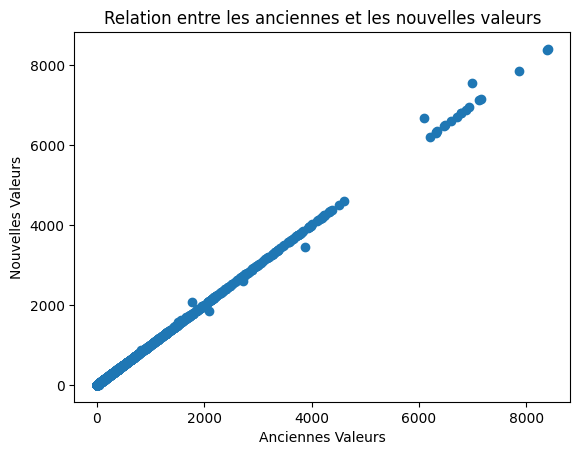

In [27]:
scatter_plot('Gas', res_old, res_new)

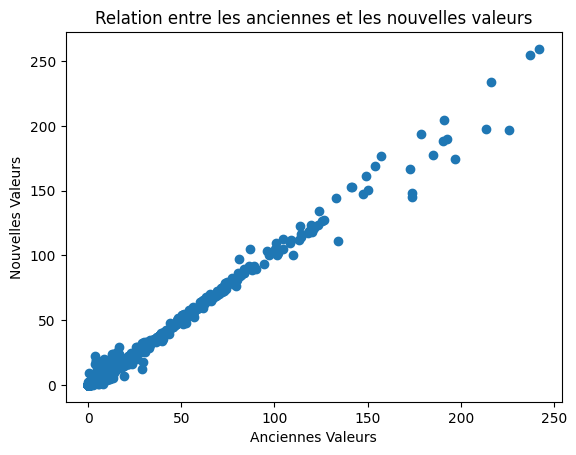

In [28]:
scatter_plot('Coal', res_old, res_new)

In [ ]:
scatter_plot('Oil', res_old, res_new)

## Remarques

**Remarque 1.**
Pour certaines pays, il existe une incohérence entre les anciennes et les nouvelles données. Les anciennes données contiennent une valeur pour l'énergie, tandis que ces informations sont absentes dans les nouvelles données. Cette différence doit être prise en compte et investiguée pour assurer la précision et la cohérence de l'ensemble des données. (le cas de l'arabe Saudi, pétrole, 2012)

In [ ]:
res_old[(res_old.group_name=='Saudi Arabia')&(res_old.year==2012)&(res_old.energy_source=='Oil')]

In [ ]:
res_new[(res_new.group_name=='Saudi Arabia')&(res_new.year==2012)&(res_new.energy_source=='Oil')]

In [ ]:
res_old[(res_old.group_name=='Saudi Arabia')&(res_old.type=='Exports')&(res_old.energy_source=='Oil')].sort_values('year')

In [ ]:
res_new[(res_new.group_name=='Saudi Arabia')&(res_new.type=='Exports')&(res_new.energy_source=='Oil')].sort_values('year')

**Remarque 2.**
Dans les anciennes données concernant le pétrole ('Oil'), l'unité utilisée est le Mb/d. Dans les nouvelles données, c'est l'unité 'TBPD' qui est employée. Lorsque je compare les données anciennes et les données mises à jour, je constate que les valeurs sont du même ordre de grandeur malgré la différence d'unités. Pourtant, 1 Mb/d équivaut à 1000 TBPD !

Voici un exemple : 

In [ ]:
res_old[(res_old.group_name=='Algeria')&(res_old.year==2012)&(res_old.energy_source=='Oil')]

In [ ]:
res_new[(res_new.group_name=='Algeria')&(res_new.year==2012)&(res_new.energy_source=='Oil')]

In [61]:
res_old.year.sort_values()

0        1980
21454    1980
21453    1980
21452    1980
21451    1980
         ... 
16557    2016
100      2016
16594    2016
16355    2016
63522    2016
Name: year, Length: 63523, dtype: int64